In [1]:
import torch, os
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\ESKO\PYWORK\NHITS


In [2]:
torch.cuda.is_available()

True

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.auto import NHITS, AutoTFT
from neuralforecast.models import LSTM, NHITS, RNN
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mse, mae, mape

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [4]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

df2 = pd.read_csv('./data/metal_ftr.csv')
df2.rename(columns={'date':'ds'},inplace=True)
df2['ds'] = pd.to_datetime(df2['ds'], format='%Y-%m-%d')

static_df = pd.read_csv('./data/static_df.csv')

df3 = pd.read_csv('./data/metal_pst_list.csv',encoding='cp949')
df_pst_list = df3.loc[0:].values.flatten().tolist()
df_date = df[['ds','unique_id','y']]
df_features = df[df_pst_list]
df_combined = pd.concat([df_date, df_features], axis=1)
# df_combined.to_csv('./data/df_combined.csv',encoding='cp949',index=False)

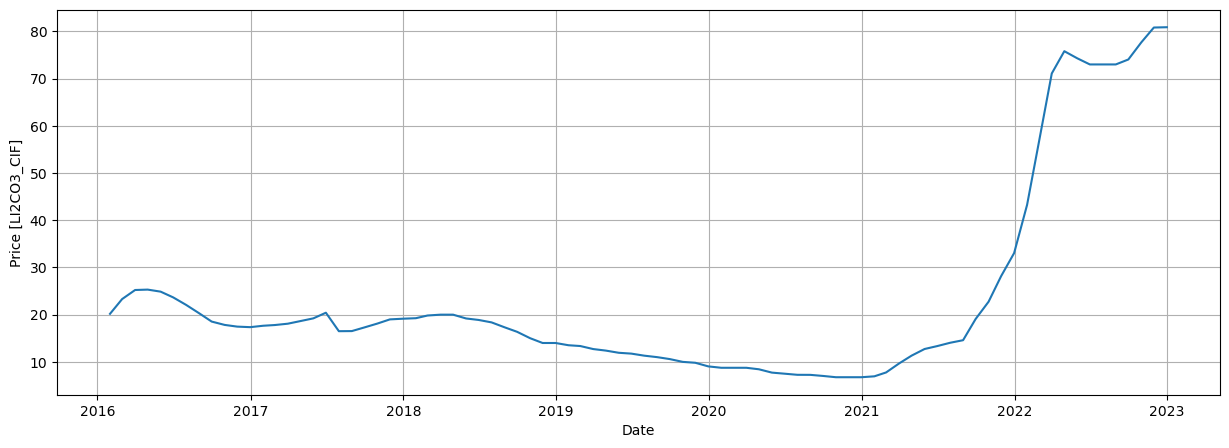

In [5]:
plt.figure(figsize=(15,5))
plt.plot(df['ds'], df['y'])
plt.xlabel('Date')
plt.ylabel('Price [LI2CO3_CIF]')
plt.grid()

In [74]:
horizon = 12

models = [
         # LSTM(h=horizon,                    # Forecast horizon
         #       gpus=1,
         #       max_epochs=500
         #       futr_exog_list = df2.columns[2:].values.flatten().tolist(),
         #       hist_exog_list = df.columns[4:].values.flatten().tolist(),
         #       # hist_exog_list = df.columns[4:].values.flatten().tolist(),
         #       scaler_type='robust',       # Type of scaler to normalize data
         #       encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
         #       decoder_hidden_size=64,),
          # AutoTFT(h=horizon,
          #         gpus=1,
          #         loss=MAE(),
          #         config=None,
          #         # futr_exog_list = df2.columns[2:].values.flatten().tolist(),
          #         # hist_exog_list = df_combined.columns[1:].values.flatten().tolist(),
          #         num_samples=12),
          NHITS(h = horizon,
                gpus=1,
                input_size = 2*horizon,
                hist_exog_list = df.columns[4:].values.flatten().tolist(),
                futr_exog_list = df2.columns[2:].values.flatten().tolist(),
                # hist_exog_list = df.columns[4:].values.flatten().tolist(),
                max_steps=100,
                # stat_exog_list =
                scaler_type = 'robust')]

In [75]:
df2.columns[2:].values.flatten().tolist()

['Shanghai Containerized Freight Index (SCFI)',
 '대두 [미국(생산자 가격)] 현물',
 '대두유 crude and refined average price [파라나구아(FOB)] 현물',
 '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
 'GDP_SAU',
 'HOUSECOST_KOR',
 'PPP_POL',
 'PPP_SRB']

In [82]:
df.columns[4:].values.flatten().tolist()

['Baltic Dry Index (BDI)',
 'Howe Robinson Container Index',
 'Shanghai Containerized Freight Index (SCFI)',
 '옥수수 For Grain [미국(생산자 가격)] 현물',
 '원당 (daily) [ISA] 현물',
 '대두 [미국(생산자 가격)] 현물',
 '대두박 [파라나구아(FOB)] 현물',
 '대두유 crude and refined average price [파라나구아(FOB)] 현물',
 '원면 [브라질(수출가 FOB)] 현물',
 '소맥 Durum [미국(생산자 가격)] 현물',
 '커피 Arabicas [미국/유럽] 현물',
 '금 [LBMA] 현물',
 '은 99.99% [SGE] 현물',
 '탄화규소 88% 0-10mm [중국(FOB)] 현물',
 '텅스텐 Ferro [북미(FOB)] 현물',
 '미국 레드북 소매판매지수',
 '미국 건축허가',
 '미국 신규주택착공건수',
 '미국 신규실업급여신청자수',
 '미국 비농업부문고용',
 '미국 소비자물가지수',
 '미국 근원소비자물가지수',
 '미국 시간당평균급여',
 '미국 2년만기 국채 수익률',
 '미국 10년만기 국채 수익률',
 '미국 생산자물가지수',
 '주당노동시간',
 'WTI [CME(NYMEX)] 2022.09',
 'WTI [CME(NYMEX)] 2022.10',
 'WTI [CME(NYMEX)] 2022.11',
 'WTI [CME(NYMEX)] 2022.12',
 'WTI [CME(NYMEX)] 2023.01',
 '미국 제조업 PMI 지수',
 '인도네시아 제조업 PMI 지수',
 '유로존 제조업 PMI 지수',
 '중국 HSBC 제조업 PMI 지수',
 '러시아 제조업 PMI 지수',
 '일본 제조업 PMI 지수',
 '캐나다 PMI',
 '한국 PMI',
 '호주 제조업 PMI 지수_호주 PMI',
 'LGES 리튬소요량_탄산리튬(kg)',
 'LGES 리튬소요량_수산화리튬(kg)',


In [77]:
%%time
nf = NeuralForecast(models=models, freq='M')
# nf.fit(df=df_combined,static_df=static_df)
nf.fit(df=df,static_df=static_df)

Epoch 0:  50%|███████████████               | 1/2 [00:00<00:00,  2.82it/s, loss=5.41, v_num=370, train_loss_step=5.410]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███   | 1/2 [00:00<00:00,  8.69it/s, loss=5.33, v_num=370, train_loss_step=5.240, train_loss_epoch=5.410]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███   | 1/2 [00:00<00:00, 10.19it/s, loss=4.78, v_num=370, train_loss_step=3.700, train_loss_epoch=5.240]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███   | 1/2 [00:00<00:00,  9.66it/s, loss=4.17, v_num=370, train_loss_step=2.310, train_loss_epoch=3.700]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███   | 1/2 [00:00<00:00, 10.69it/s, loss=3.98, v_num=370, train_loss_step=3.260, train_loss_epoch=2.310]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███   | 1/2 [00:00<00:00, 10.84it/s, loss=3.65, v_num=370, train_loss_step=1.960, train_loss_epoch=3.260]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███   | 1/2 [00:00<00:00, 10.39it/s, loss=3.38, v_num=370, train_loss_step=1.760

In [78]:
futr_df = pd.read_csv('./data/metal_ftr.csv')
futr_df.rename(columns={'date':'ds'},inplace=True)
futr_df['ds'] = pd.to_datetime(futr_df['ds'], format='%Y-%m-%d')

Y_hat_df = nf.predict(futr_df=futr_df)
Y_hat_df.to_csv('NHITS_forecasting.csv')

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.60it/s]


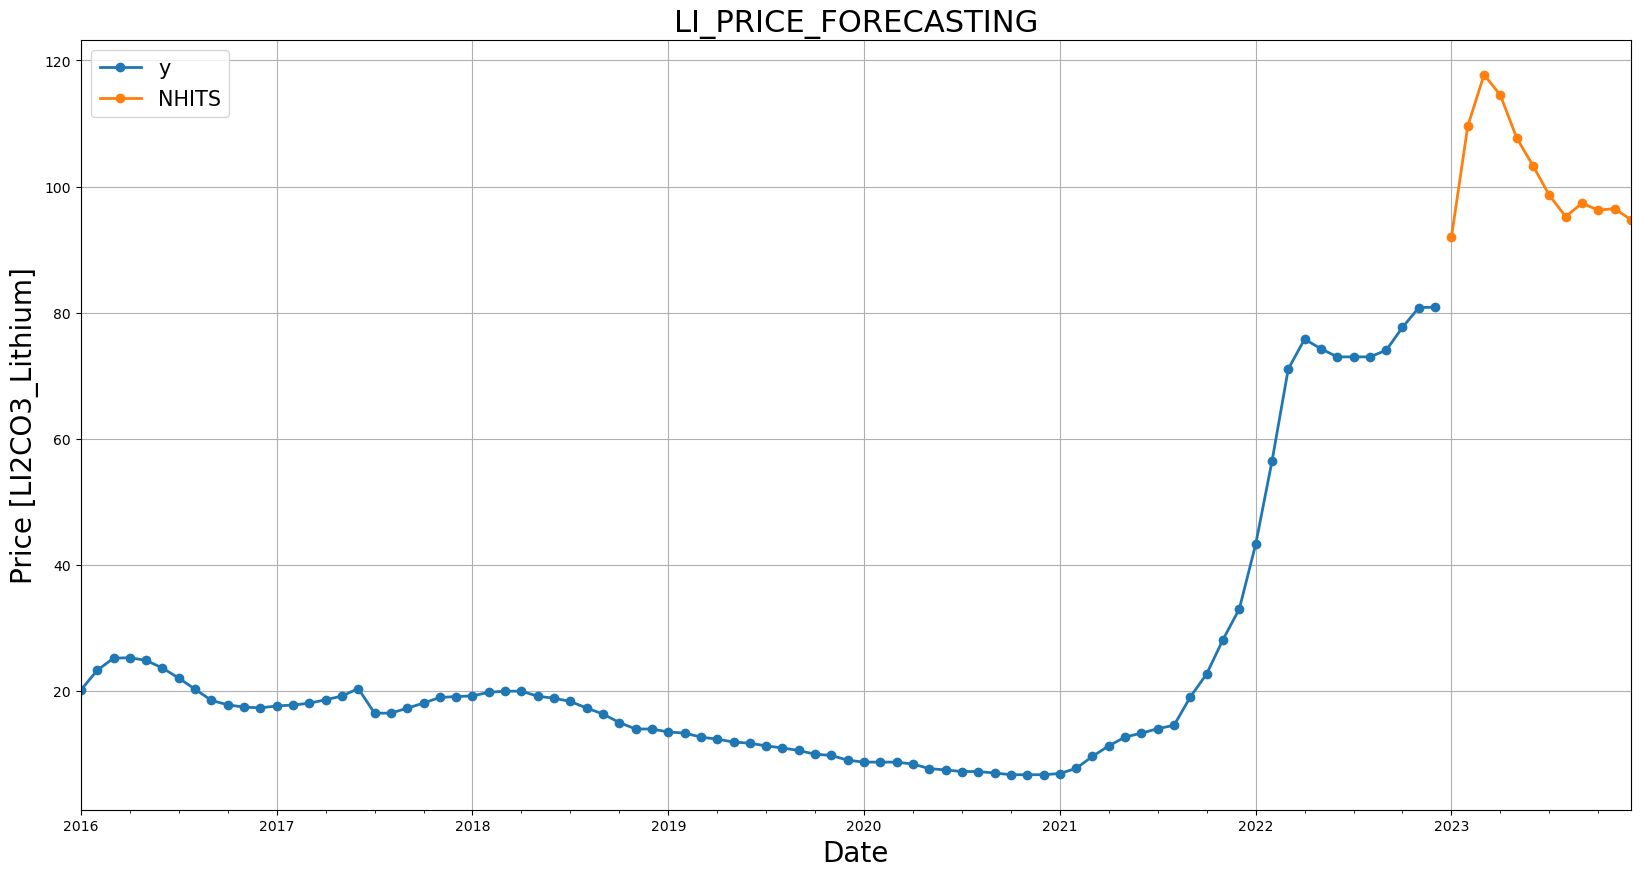

In [85]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
plot_df = df.reset_index(drop=True)
plot_df2 = pd.concat([plot_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df2[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')

ax.set_title('LI_PRICE_FORECASTING', fontsize=22)
ax.set_ylabel('Price [LI2CO3_Lithium]', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()